In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from scipy.spatial import distance

In [2]:
dfAbnormal1 = pd.read_csv("../cleanData/clean_abnormal1.csv")
dfnormal1 = pd.read_csv("../cleanData/clean_normal.csv")
dfAbnormal = pd.read_csv("../cleanData/clean_abnormal1.csv")
dfnormal = pd.read_csv("../cleanData/clean_normal.csv")


dfAbnormal_1 = pd.concat([dfAbnormal, dfAbnormal1], ignore_index=True)
dfnormal_1 = pd.concat([dfnormal, dfnormal1], ignore_index=True)

In [34]:
np.shape(df_combined)

(207678, 20)

In [4]:
# Define number of top features to select
k = 5  # Adjust this value as needed

# Combine datasets and add label columns
dfAbnormal_1['Label'] = 1
dfnormal_1['Label'] = 0
df_combined = pd.concat([dfAbnormal_1, dfnormal_1], ignore_index=True)

# Separate features and target
X = df_combined.drop(columns='Label')
y = df_combined['Label']

# Apply SelectKBest with f_regression
selector = SelectKBest(score_func=f_regression, k=k)
X_new = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support(indices=True)]
print(f'Selected top {k} features using SelectKBest with f_regression:')
for feature in selected_features:
    print(feature)

# Create a new dataframe with selected features and labels
df_selected = pd.DataFrame(X_new, columns=selected_features)
df_selected['Label'] = y.values


Selected top 5 features using SelectKBest with f_regression:
TEMP
MIN_BLOOD
PULSE
SYRINGE_FLOW
BREATH


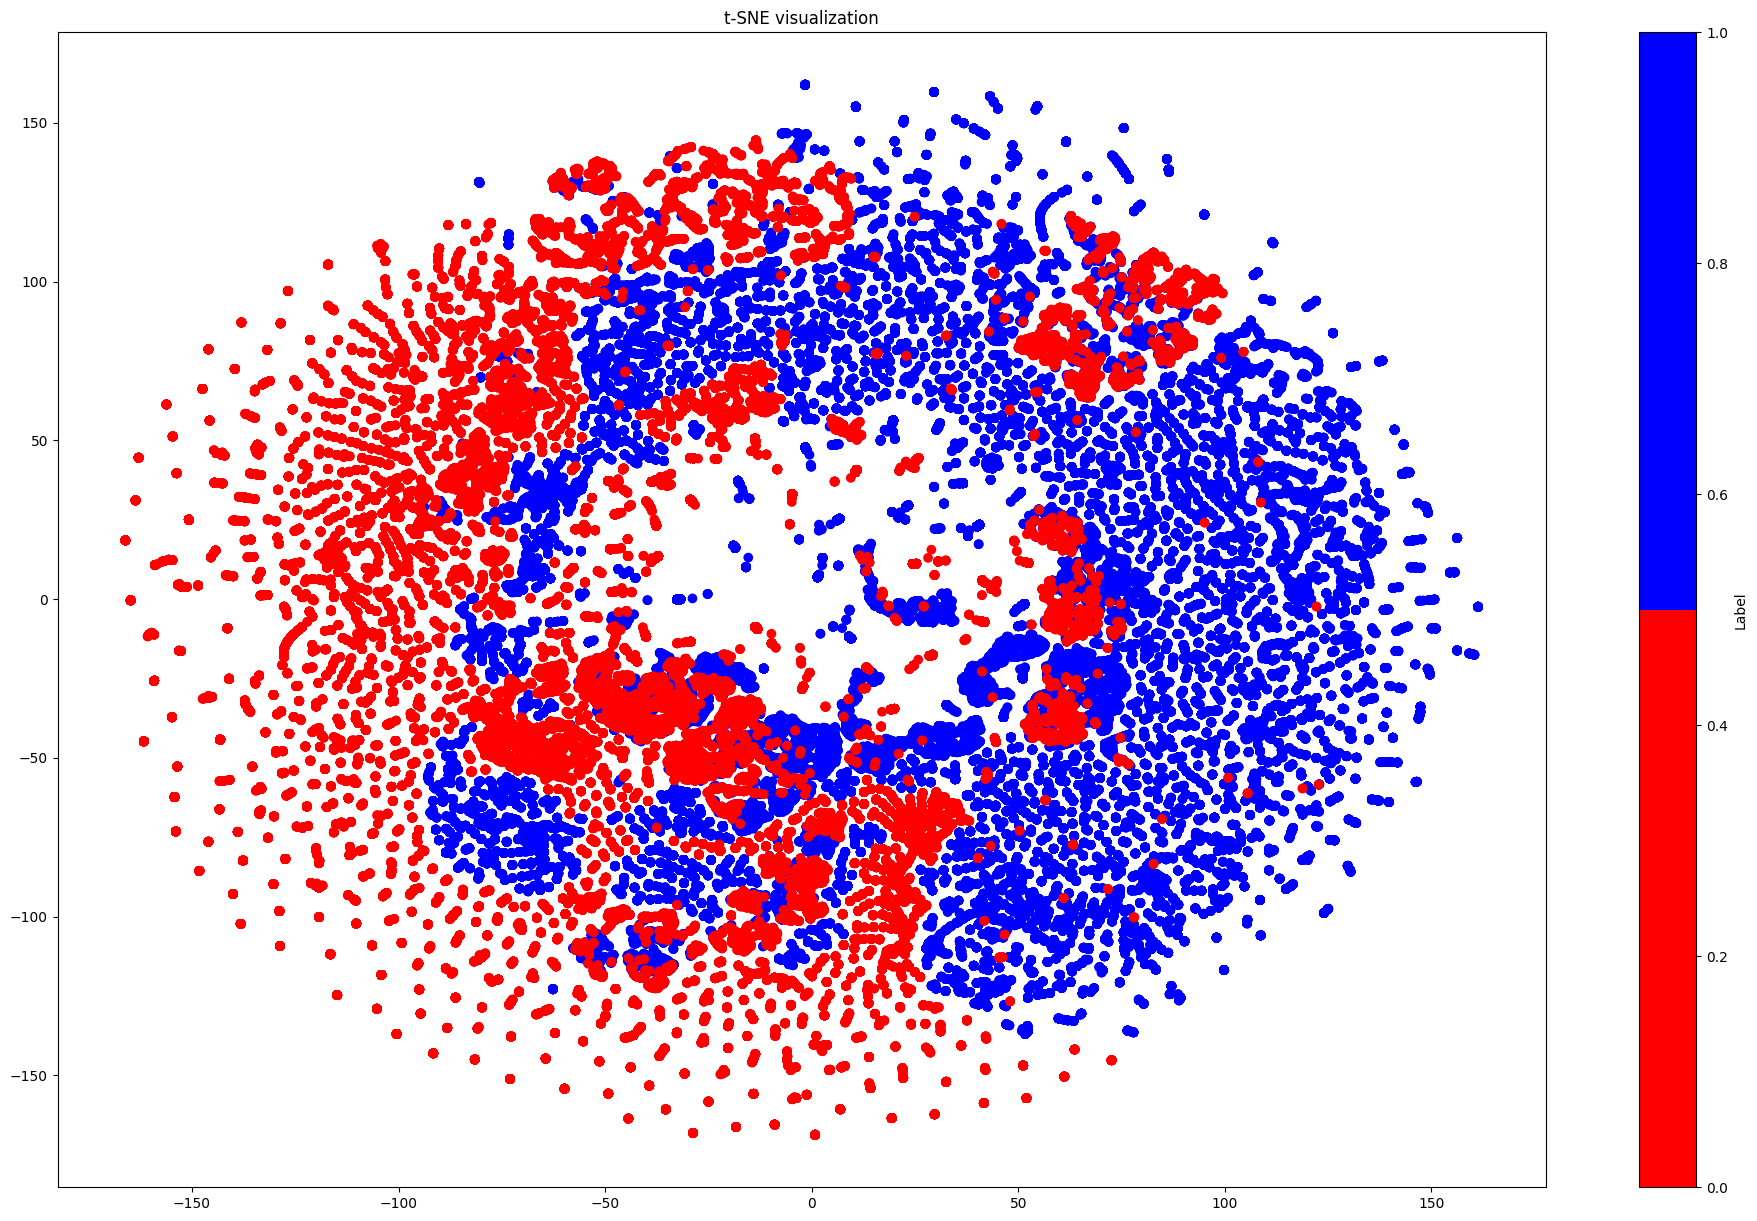

In [5]:
# Standardize the data
X_standardized = StandardScaler().fit_transform(df_selected.drop(columns='Label'))

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_standardized)

# Create a new dataframe with t-SNE results
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['Label'] = df_selected['Label']


# Plot t-SNE results
plt.figure(figsize=(24, 15))
scatter = plt.scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], c=df_tsne['Label'], cmap=ListedColormap(['red', 'blue']))
plt.title('t-SNE visualization')
plt.colorbar(scatter, label='Label')
plt.show()


In [25]:
df_tsne

,TSNE1,TSNE2,Label
0,78.665047,69.890984,1
1,63.157440,2.579798,1
2,-39.679352,61.289478,1
3,53.932484,24.736952,1
4,14.923249,93.116249,1
...,...,...,...
207673,-23.597216,58.586151,0
207674,-28.606619,-111.585396,0
207675,-23.597216,58.586151,0
207676,-36.691566,56.255028,0


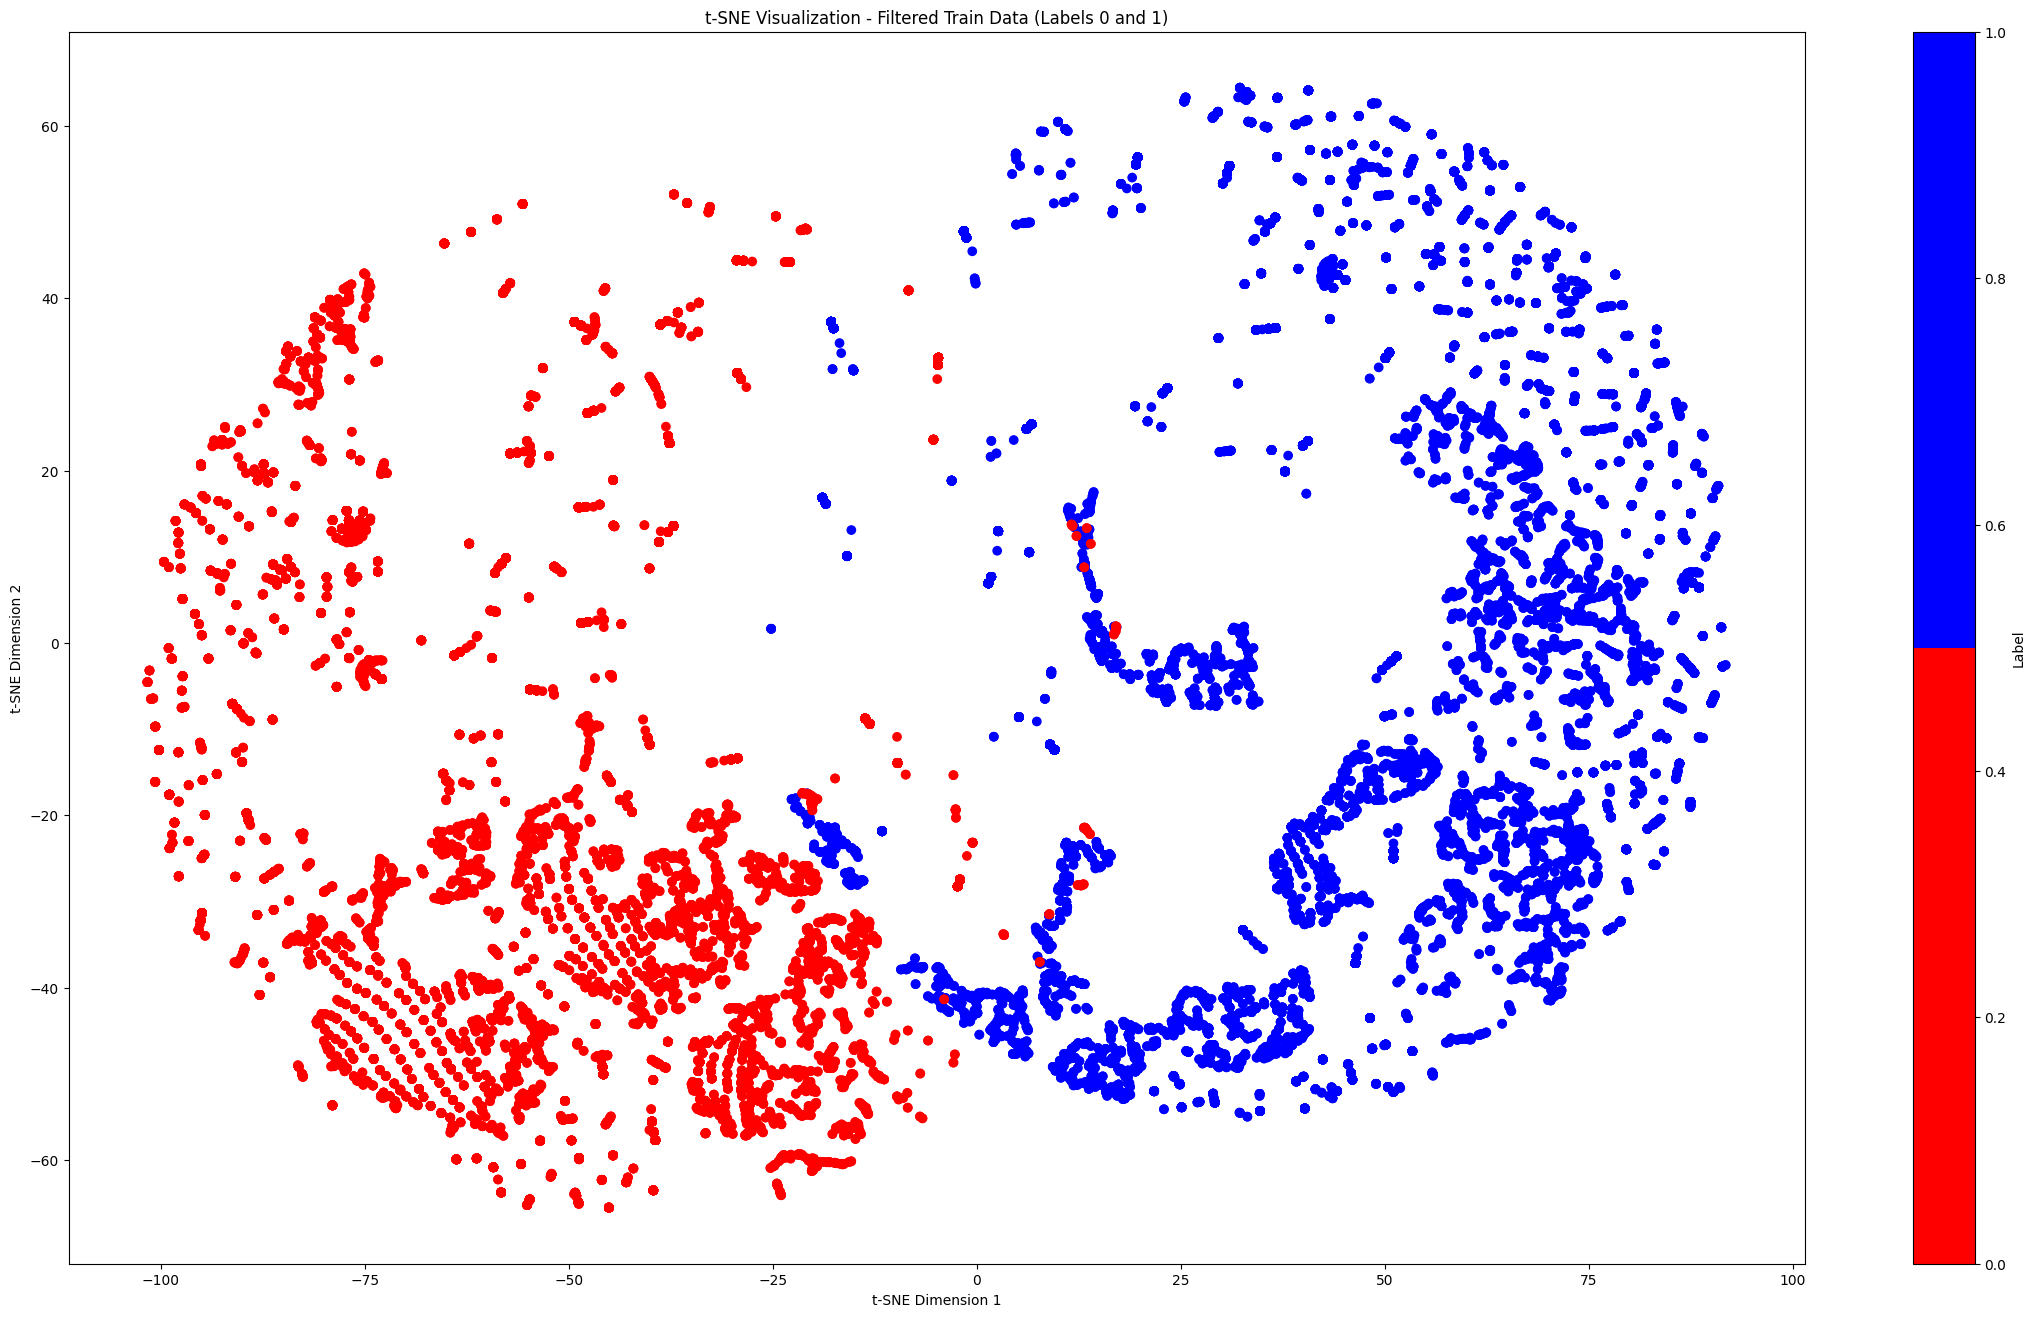

In [21]:
# 创建一个新的DataFrame包含t-SNE结果
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['Label'] = df_selected['Label']

# 将数据分为训练和测试集 (这里需要您具体的训练和测试集划分逻辑)
train_tsne_embedded = df_tsne[['TSNE1', 'TSNE2']].values  # 替换为实际的训练集嵌入结果
train_labels = df_tsne['Label'].values  # 替换为实际的训练集标签
# 计算类别的中心点
def compute_class_centers(points, labels):
    unique_labels = np.unique(labels)
    centers = {}
    for label in unique_labels:
        centers[label] = np.mean(points[labels == label], axis=0)
    return centers

# 定义阈值来过滤数据
distance_threshold = 60  # 这是一个示例阈值，请根据实际情况调整

# 筛选标签为0和1的训练数据点
train_mask = np.isin(train_labels, [0, 1])
train_tsne_embedded_01 = train_tsne_embedded[train_mask]
train_labels_01 = train_labels[train_mask]

# 计算训练数据的类别中心
train_class_centers = compute_class_centers(train_tsne_embedded_01, train_labels_01)

# 过滤训练数据
filtered_train_points = []
filtered_train_labels = []
for i, point in enumerate(train_tsne_embedded_01):
    label = train_labels_01[i]
    center = train_class_centers[label]
    if distance.euclidean(point, center) < distance_threshold:
        filtered_train_points.append(point)
        filtered_train_labels.append(label)

filtered_train_points = np.array(filtered_train_points)


# 可视化过滤后的训练数据
plt.figure(figsize=(28, 16))
plt.scatter(filtered_train_points[:, 0], filtered_train_points[:, 1], c=filtered_train_labels, cmap=ListedColormap(['red', 'blue']))
plt.title('t-SNE Visualization - Filtered Train Data (Labels 0 and 1)')
plt.colorbar(label='Label')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


In [45]:
# 创建一个哈希表，以加快查找速度
point_to_index = {tuple(point): index for index, point in enumerate(train_tsne_embedded)}

# 使用哈希表查找每个点的索引
indices = np.array([point_to_index[tuple(point)] for point in filtered_train_points])

selected_rows = df_combined.iloc[indices]

df_final = pd.DataFrame(selected_rows)

In [47]:
df_final

,TEMP,MIN_BLOOD,PULSE,SYRINGE_FLOW,BREATH,Label
56646,36.3,72.0,77.0,3.062776,18.0,1
56648,36.0,66.0,84.0,3.500000,14.0,1
56666,36.9,68.0,81.0,3.062776,18.0,1
56672,36.6,71.0,92.0,3.500000,17.0,1
56674,36.6,53.0,92.0,3.500000,16.0,1
...,...,...,...,...,...,...
207610,37.3,64.0,62.0,3.000000,16.0,0
207623,37.3,66.0,58.0,2.957738,15.0,0
207632,37.2,74.0,75.0,2.957738,15.0,0
207637,37.2,69.0,82.0,3.000000,15.0,0


In [49]:
df_final.to_csv("../cnnData/kSelector.csv")